In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
#from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import interp1d
from astropy.cosmology import Planck15
from datetime import datetime
c = 299792458 #speed of light m s^-1
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
libdir = '/Users/cv/sed_research/'

def read_params(paramfile):
    params = {}
    params["Filters"] = {}
    with open(paramfile) as f:
        for line in f:
            #print line.split()
            if line[0] != "#":
                ls = line.split()
                params["Filters"][ls[0]] = {}
                params["Filters"][ls[0]]["lam_c"] = np.float(ls[1])
                params["Filters"][ls[0]]["delt_lam"] = np.float(ls[2])
                params["Filters"][ls[0]]["5sigma"] = np.float(ls[3])
                params["Filters"][ls[0]]["filename"] = libdir + "Filters/" + ls[4]
    return params

In [3]:
class sed(object):
    "Spectral Energy Distribution Object"
    def __init__(self,paramfile,templatefile):
        params = read_params(paramfile)
        self.filters = params.get("Filters")
        template = templatefile
        self.loglam,self.lognuLnu = np.loadtxt(template,usecols=(0,1), delimiter=" ", unpack=True)
        self.nuLnu = np.power(10.,self.lognuLnu)
        self.lam = np.power(10.,self.loglam)
        #self.ilognuLnu = interp1d(self.loglam,self.lognuLnu)
        #loading filters
        for Filter in self.filters:
            lam,trans = np.loadtxt(self.filters[Filter]["filename"],usecols =(0,1),delimiter=" ",unpack=True)
            #Pass wavelength from Angstrom to microns
            self.filters[Filter]["lam"] = lam*1e-4
            self.filters[Filter]["trans"] = trans
        #For Filters Photometry
        #self.phot_cen = []
        #self.phot = []
        #self.lam_eff = []
        #self.labels = []
        
    def redshift(self,z):
        #Applying a redshift
        self.z = z
        self.nuFnu = (self.nuLnu/(4*np.pi*Planck15.luminosity_distance(z).value**2))
        self.lam_new = self.lam*(1.+z)
        #to Jansky
        self.Fnu = self.nuFnu*(self.lam_new*1e-6/c)*1e-10*1e23
        #Interpolated nuFnu
        self.inuFnu = interp1d(self.lam_new,self.nuFnu)
        self.iFnu = interp1d(self.lam_new,self.Fnu)
        
    def photometry(self):
        self.SNR = []
        self.phot_err = []
        self.phot_c = []
        self.phot = []
        self.lam_eff = []
        self.lam_c = []
        self.lam_err = []
        self.labels = []
        self.det = [] #Detections of upper_limits
        #Gets the photometry of all the filters
        for Filter in self.filters:
            lam = self.filters[Filter]["lam"]
            trans = self.filters[Filter]["trans"]
            Fnu = self.iFnu(lam)
            #Doing the integral for photometry - effective stimulus
            #This is the central photometry
            phot_c = np.trapz(Fnu*trans*lam,lam)/np.trapz(trans*lam,lam)
            self.phot_c.append(phot_c)
            
            #Calculating sigma_flux in Jy
            
            fivesigma_mag = self.filters[Filter]["5sigma"]
            
            sigma_flux = (10**(-(fivesigma_mag + 48.6)/2.5)*1e23)/5.
            
            #Random realization
            phot = np.random.normal(loc=phot_c,scale=sigma_flux)
            
            if phot<0:
                phot=0.
            
            #self.phot.append(phot)
            
            #Calculating SNR
            SNR = phot/sigma_flux
            self.SNR.append(SNR)
            
            #print "{}    {}    {}    {}".format(Filter,sigma_flux,phot,SNR)
            
            if SNR>3.:
                self.det.append("det")
                self.phot_err.append(sigma_flux)
                self.phot.append(phot)
            #Treatment of non detections
            else:
                self.det.append("up_lim")
                #Adding the treatment of 3/2
                
                phot = (3./2.)*sigma_flux
                phot_err = (3./2.)*sigma_flux
                
                #Randomizing the value
                #phot = np.random.normal(loc=phot,scale=phot_err)
                self.phot.append(phot)
                self.phot_err.append(phot_err)
                
            #Doing the integral for effective wavelength
            lam_eff = np.trapz(Fnu*trans*lam*lam,lam)/np.trapz(Fnu*trans*lam,lam)
            self.lam_eff.append(lam_eff)
            self.lam_c.append(self.filters[Filter]["lam_c"])
            self.lam_err.append(self.filters[Filter]["delt_lam"]/2.)
            self.labels.append(Filter)
            
    def plot_sed(self,scale="normal",color="blue",linewidth=0.5):
        #Plotting the SED and the possible Photometry
        #plt.title("mysed; z={}".format(self.z))
        plt.ylabel(r"$F_{\nu}$[Jy]")
        plt.xlabel("$\lambda$ [$\mu$m]")
        if scale=="normal":
            plt.plot(self.lam_new,self.iFnu(self.lam_new),color=color,linewidth=linewidth,label="{}".format(self.z))
        if scale=="loglog":
            plt.loglog(self.lam_new,self.iFnu(self.lam_new),color=color,label="{}".format(self.z))
        
    def plot_filters(self,norm):
        for Filter in self.filters:
            lam = mysed.filters[Filter]["lam"]
            trans = mysed.filters[Filter]["trans"]*norm
            plt.plot(lam,trans,label = Filter)

In [4]:
parfile = '/Users/cv/sed_research/params/full.par'
tempfile = '/Users/cv/sed_research/Templates/ARP220_loglam_lognuLnu.txt'

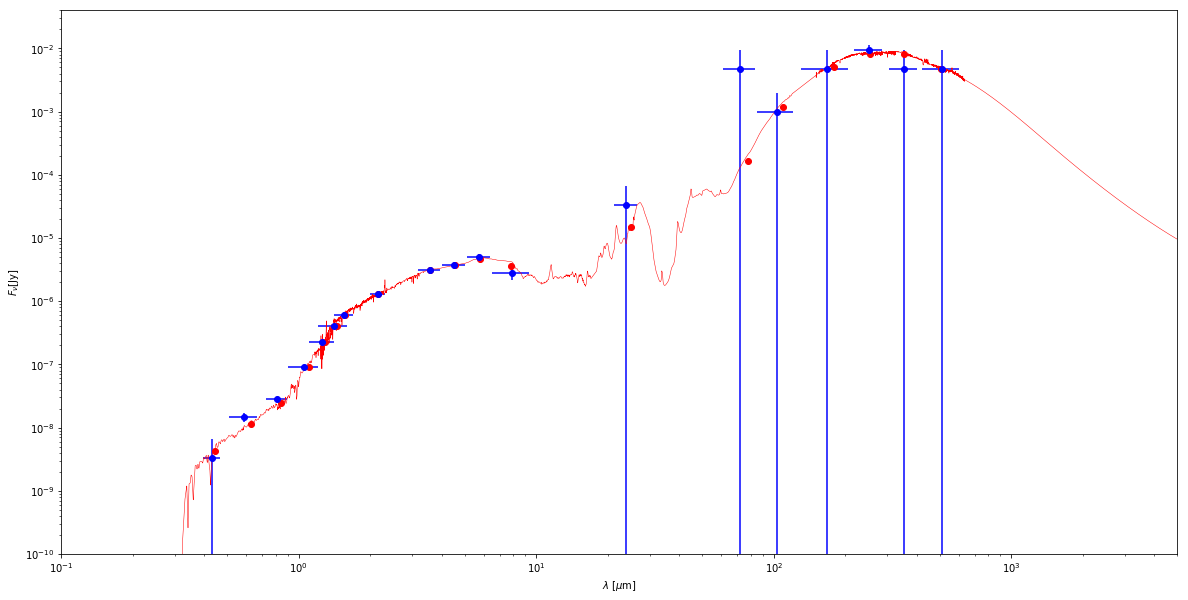

In [5]:
z = 2.5
mysed = sed(parfile,tempfile)
mysed.redshift(z)
mysed.photometry()

ax = plt.subplot(111)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

plt.errorbar(mysed.lam_c, mysed.phot, xerr=mysed.lam_err, yerr=mysed.phot_err,fmt="bo",ecolor="blue")
plt.plot(mysed.lam_eff, mysed.phot_c, "ro")
mysed.plot_sed(scale="normal",color="red")
#plt.plot(mysed.lam_eff,mysed.phot_c,"ro")

#mysed.plot_filters(1e-8)
plt.ylim(1e-10,4e-2)
plt.xlim(1e-1,5e3)
#plt.legend(loc="lower right")
plt.show()

In [6]:
for i in range(10):
    
    startTime = datetime.now()
    
    z = 2.3
    mysed = sed(parfile,tempfile)
    mysed.redshift(z)
    mysed.photometry()

    print datetime.now() - startTime
    
    ax = plt.subplot(111)
    ax.set_xscale("log", nonposx='clip')
    ax.set_yscale("log", nonposy='clip')

    plt.errorbar(mysed.lam_c, mysed.phot, xerr=mysed.lam_err, yerr=mysed.phot_err,fmt="bo",ecolor="blue")
    plt.plot(mysed.lam_eff, mysed.phot_c, "ro")
    mysed.plot_sed(scale="normal",color="red")
    #plt.plot(mysed.lam_eff,mysed.phot_c,"ro")

    #mysed.plot_filters(1e-8)
    plt.ylim(1e-10,4e-2)
    plt.xlim(1e-1,5e3)
    #plt.legend(loc="lower right")
    plt.savefig("comparison_z{}_{}.png".format(z,i),dpi=150)
    plt.clf()

0:00:04.166816
0:00:03.605796
0:00:04.387143
0:00:07.194922
0:00:04.886761
0:00:03.991578
0:00:03.807856
0:00:03.231522
0:00:02.925946
0:00:02.943428
